# RNN training reproduces data

In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, pearsonr, spearmanr, wilcoxon
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from statsmodels.stats.weightstats import DescrStatsW

sys.path.append('../src/model_rnn/')
from rnn_bias import *

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/rnn")

with open('../data/outputs/rnn/het/agg_early.pkl', 'rb') as f:
    resE = pickle.load(f)
with open('../data/outputs/rnn/het/agg_late.pkl', 'rb') as f:
    resL = pickle.load(f)

with open('../data/outputs/rnn/het_emonly/agg_early.pkl', 'rb') as f:
    resE_emonly = pickle.load(f)
with open('../data/outputs/rnn/het_emonly/agg_late.pkl', 'rb') as f:
    resL_emonly = pickle.load(f)

downloading data/outputs/rnn...
data/outputs/rnn already exists. Skipping download...


---
## Stimulus-specific bias

In [3]:
err_concat = np.concatenate([resE['er_behav_agg'],resL['er_behav_agg']],axis=0)
res_ssb = np.nan*np.zeros((50,24,2,3))

In [4]:
n_batch, n_ori = 128, 24
def nll(params, evi, dm):
    m, s, lam = params
    prob      = utils.psi(evi, m, s, lam)
    prob_cw   = prob[dm==1.]
    prob_ccw  = prob[dm==0.]
    prob_cw[prob_cw<utils.EPS] = utils.EPS
    prob_ccw[prob_ccw>1.-utils.EPS] =1.-utils.EPS
    
    sum_ll    = np.sum(np.log(prob_cw)) + np.sum(np.log(1.-prob_ccw))
    return -sum_ll

In [5]:
# this can take some time (~1min)
for i_data, v_data in enumerate([resE, resL]):
    for i_model in range(50):
        n_success = 0
        for i_s in range(n_ori):
            dm_behav_agg = v_data['dm_behav_agg'][i_model][i_s] 
            evidence = -np.repeat(np.arange(-30,30+utils.EPS,step=7.5), n_batch)       
            dm_rnn   = 1-dm_behav_agg.reshape((-1))

            res_min = minimize(nll, [0,6.,0], 
                               args=(evidence, dm_rnn), 
                               bounds=[[-20., 20.], [utils.EPS, 30.], [0, 0.3]])
            res_ssb[i_model,i_s,i_data] = res_min['x']
            n_success += res_min['success']

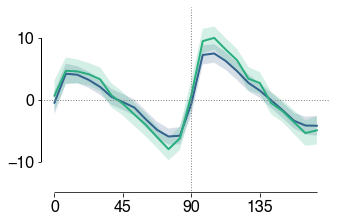

In [6]:
mE = np.mean(-res_ssb[:,:,0,0],axis=0)
sE = np.std( -res_ssb[:,:,0,0],axis=0)/np.sqrt(50)
mL = np.mean(-res_ssb[:,:,1,0],axis=0)
sL = np.std( -res_ssb[:,:,1,0],axis=0)/np.sqrt(50)

plt.figure()
ax = plt.gca()
utils.set_size([3.8,2.5])

plt.plot(np.arange(180,step=7.5), mE, color='#33638D',linewidth=2)
plt.plot(np.arange(180,step=7.5), mL, color='#29AF7F',linewidth=2)

plt.axvline(x=90, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)
plt.fill_between(x=np.arange(180,step=7.5), y1=mE-sE, y2=mE+sE, color='#33638D', alpha=0.2, edgecolor="none")
plt.fill_between(x=np.arange(180,step=7.5), y1=mL-sL, y2=mL+sL, color='#29AF7F', alpha=0.2, edgecolor="none")
plt.ylim([-15,15])
    
if utils.LABEL:
    plt.xlabel(r"Stimulus $(\!\!^\circ\!\!)$")    
    plt.ylabel(r"Bias at $t_\mathrm{DM}$ $(\!\!^\circ\!\!)$")

utils.draw_publish_axis(ax, xrange=(0,172.5), yrange=(-10,10), xticks=[0,45,90,135], yticks=[-10,0,10])
plt.savefig(f'{utils.DIR_FIGURE}/fig7d_left.pdf',bbox_inches='tight')
plt.show()

In [7]:
bias_weights = np.zeros((50,2)) * np.nan

for i_m in range(50):
    final_pat = np.stack([err_concat[i_m],err_concat[i_m+50]],axis=0)
    final_pat = utils.circmean(final_pat, axis=(0,2,3))
    
    e_pattern = - res_ssb[i_m,:,0,0]
    l_pattern = - res_ssb[i_m,:,1,0]
    
    reg = LinearRegression(fit_intercept=False).fit(final_pat.reshape(-1,1),e_pattern)
    bias_weights[i_m,0] = reg.coef_[0]
    reg = LinearRegression(fit_intercept=False).fit(final_pat.reshape(-1,1),l_pattern)
    bias_weights[i_m,1] = reg.coef_[0]

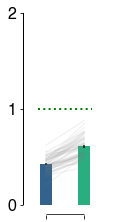

In [8]:
ms = [np.mean(bias_weights[:,0]), np.mean(bias_weights[:,1])]
ss = [np.std(bias_weights[:,0])/np.sqrt(50), np.std(bias_weights[:,1])/np.sqrt(50)]

plt.figure()
ax = plt.gca()
utils.set_size([1.4,2.5])

for i in range(50):
    plt.plot([-1,1.5], [bias_weights[i,0],bias_weights[i,1]], color='gray', alpha=0.09)
    
plt.bar(x=[-1,1.5], height=ms, color=["#33638D", "#29AF7F"])
plt.errorbar(x=[-1,1.5], y=ms, yerr=ss, fmt="none", color="k")
plt.xlim([-2.5,3])
plt.ylim([-0.1,2])

ax.hlines(y=1, xmin=-1.5, xmax=2, linestyle='dotted', color='green', linewidth=2.)

if utils.LABEL:
    plt.ylabel(r"Bias weight", labelpad=10)
    plt.xticks([-1,1.5], ['Early', 'Late'])
else:
    plt.xticks([-1,1.5], ['', ''])
utils.draw_publish_axis(ax, xrange=(-1,1.5), yrange=(0,2), xticks=None, yticks=[0,1,2])
plt.savefig(f'{utils.DIR_FIGURE}/fig7d_right.pdf',bbox_inches='tight')
plt.show()

In [9]:
ttest  = DescrStatsW(bias_weights[:,1]-bias_weights[:,0])
wilcox = wilcoxon(bias_weights[:,1]-bias_weights[:,0])
print("Bias weight: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Bias weight: Early vs. Late

Paired samples t-test
t(49)= 16.01949633422395 p= 4.108297783658225e-21
95% CI= (0.1640052850357154, 0.21105493746228868)

Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 7.556929455863566e-10


---
## Decision-consistent bias

In [10]:
dcb_ref_agg  = np.nan*np.zeros([2,50,2,5])

for i_m in range(50):
    for i_r, v_r in enumerate([7,5,4,3,1]):        
        dcb_ref_agg[0,i_m,0,i_r] = utils.circmean(resE['er_behav_agg'][i_m,:,v_r][resE['dm_behav_agg'][i_m,:,v_r]==1.])
        dcb_ref_agg[0,i_m,1,i_r] = utils.circmean(resE['er_behav_agg'][i_m,:,v_r][resE['dm_behav_agg'][i_m,:,v_r]==0.])    

        dcb_ref_agg[1,i_m,0,i_r] = utils.circmean(resL['er_behav_agg'][i_m,:,v_r][resL['dm_behav_agg'][i_m,:,v_r]==1.])
        dcb_ref_agg[1,i_m,1,i_r] = utils.circmean(resL['er_behav_agg'][i_m,:,v_r][resL['dm_behav_agg'][i_m,:,v_r]==0.])

In [11]:
%%capture
dcb_ref_agg[:,:,1,0] = np.nan
dcb_ref_agg[:,:,0,4] = np.nan
m_dcb_ref_agg = np.nanmedian(dcb_ref_agg,axis=1)
s_dcb_ref_agg = np.nanstd(dcb_ref_agg,axis=1)/np.sqrt(50) * 1.96

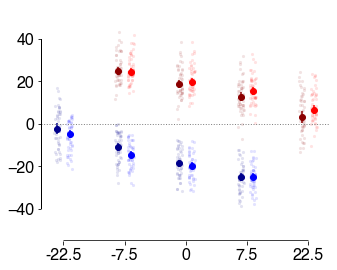

In [12]:
plt.figure()
ax = plt.gca()
utils.set_size([3.8,3])

devi = 0.1
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

# Early
plt.scatter(np.array([-2,-1,0,1,2])-devi, (m_dcb_ref_agg)[0,1,:], color='darkred')
plt.vlines( np.array([-2,-1,0,1,2])-devi, (m_dcb_ref_agg-s_dcb_ref_agg)[0,1,:], (m_dcb_ref_agg+s_dcb_ref_agg)[0,1,:], color='darkred')
for i_r,v_r in enumerate([-2,-1,0,1,2]):    
    plt.scatter(np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                dcb_ref_agg[0,:,1,i_r].T, color='darkred', alpha=0.11, linewidth=0, s=10, zorder=0)

plt.scatter(np.array([-2,-1,0,1,2])-devi, (m_dcb_ref_agg)[0,0,:], color='darkblue')
plt.vlines( np.array([-2,-1,0,1,2])-devi, (m_dcb_ref_agg-s_dcb_ref_agg)[0,0,:], (m_dcb_ref_agg+s_dcb_ref_agg)[0,0,:], color='darkblue')
for i_r,v_r in enumerate([-2,-1,0,1,2]):    
    plt.scatter(np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                dcb_ref_agg[0,:,0,i_r].T, color='darkblue', alpha=0.11, linewidth=0, s=10, zorder=0)


# Late
plt.scatter(np.array([-2,-1,0,1,2])+devi, (m_dcb_ref_agg)[1,1,:], color='red')
plt.vlines( np.array([-2,-1,0,1,2])+devi, (m_dcb_ref_agg-s_dcb_ref_agg)[1,1,:], (m_dcb_ref_agg+s_dcb_ref_agg)[1,1,:], color='red')
for i_r,v_r in enumerate([-2,-1,0,1,2]):    
    plt.scatter(np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                dcb_ref_agg[1,:,1,i_r].T, color='red', alpha=0.11, linewidth=0, s=10, zorder=0)

plt.scatter(np.array([-2,-1,0,1,2])+devi, (m_dcb_ref_agg)[1,0,:], color='blue')
plt.vlines( np.array([-2,-1,0,1,2])+devi, (m_dcb_ref_agg-s_dcb_ref_agg)[1,0,:], (m_dcb_ref_agg+s_dcb_ref_agg)[1,0,:], color='blue')
for i_r,v_r in enumerate([-2,-1,0,1,2]):    
    plt.scatter(np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                dcb_ref_agg[1,:,0,i_r].T, color='blue', alpha=0.11, linewidth=0, s=10, zorder=0)
plt.ylim([-55,55])

if utils.LABEL:
    plt.xlabel(r"Stimulus - Reference $(\!\!^\circ\!\!)$")    
    plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    

plt.xticks([-2,-1,0,1,2],[-22.5,-7.5,0,7.5,22.5])
utils.draw_publish_axis(ax, xrange=(-2,2), yrange=(-40,40), xticks=None, yticks=[-40,-20,0,20,40])
plt.savefig(f'{utils.DIR_FIGURE}/fig7b_left.pdf',bbox_inches='tight')
plt.show()

In [13]:
dcb_incr_agg = np.nan*np.zeros((2,50,2))
        
for i_m in range(50):
    dcb_incr_agg[0,i_m,0] = utils.circmean(resE['er_behav_agg'][i_m,:,3:6][resE['dm_behav_agg'][i_m,:,3:6]==1.])
    dcb_incr_agg[0,i_m,1] = utils.circmean(resE['er_behav_agg'][i_m,:,3:6][resE['dm_behav_agg'][i_m,:,3:6]==0.])    
    
    dcb_incr_agg[1,i_m,0] = utils.circmean(resL['er_behav_agg'][i_m,:,3:6][resL['dm_behav_agg'][i_m,:,3:6]==1.])
    dcb_incr_agg[1,i_m,1] = utils.circmean(resL['er_behav_agg'][i_m,:,3:6][resL['dm_behav_agg'][i_m,:,3:6]==0.])

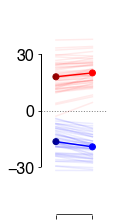

In [14]:
v_Ecw  = dcb_incr_agg[0,:,0]
v_Eccw = dcb_incr_agg[0,:,1]
v_Lcw  = dcb_incr_agg[1,:,0]
v_Lccw = dcb_incr_agg[1,:,1]

ms_cw  = [np.mean(v_Ecw), np.mean(v_Lcw)]
ss_cw  = [np.std(v_Ecw)/np.sqrt(50), np.std(v_Lcw)/np.sqrt(50)]
ms_ccw = [np.mean(v_Eccw), np.mean(v_Lccw)]
ss_ccw = [np.std(v_Eccw)/np.sqrt(50), np.std(v_Lccw)/np.sqrt(50)]

plt.figure()
ax = plt.gca()
utils.set_size([1.4,2.5])

plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.errorbar(x=[-1], y=ms_cw[0], yerr=ss_cw[0], fmt="none", color="darkblue")
plt.errorbar(x=[1.5], y=ms_cw[-1], yerr=ss_cw[-1], fmt="none", color="blue")
plt.scatter(x=[-1,1.5], y=ms_cw, color=["darkblue", "blue"])
for i in range(50):
    plt.plot([-1,1.5], [v_Ecw[i],v_Lcw[i]], color='blue', alpha=0.08)

plt.scatter(x=[-1,1.5], y=ms_ccw, color=["darkred", "red"])
plt.errorbar(x=[-1], y=ms_ccw[0], yerr=ss_ccw[0], fmt="none", color="darkred")
plt.errorbar(x=[1.5], y=ms_ccw[-1], yerr=ss_ccw[-1], fmt="none", color="red")
for i in range(50):
    plt.plot([-1,1.5], [v_Eccw[i],v_Lccw[i]], color='red', alpha=0.08)  

plt.plot([-1,1.5], [ms_cw[0], ms_cw[-1]],   color='blue', zorder=0)
plt.plot([-1,1.5], [ms_ccw[0], ms_ccw[-1]], color='red', zorder=0)
plt.xlim([-2,2.5])
plt.ylim([-55,55])
    
if utils.LABEL:
    plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    
    plt.xticks([-1,1.5], ['Early', 'Late'])
else:
    plt.xticks([-1,1.5], ['', ''])

utils.draw_publish_axis(ax, xrange=(-1,1.5), yrange=(-30,30), xticks=None, yticks=[-30,0,30])
plt.savefig(f'{utils.DIR_FIGURE}/fig7b_right.pdf',bbox_inches='tight')
plt.show()

In [15]:
ttest  = DescrStatsW((v_Lccw-v_Lcw)-(v_Eccw-v_Ecw))
wilcox = wilcoxon((v_Lccw-v_Lcw)-(v_Eccw-v_Ecw))
print("Decision-consistent bias: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Decision-consistent bias: Early vs. Late

Paired samples t-test
t(49)= 17.691510709018775 p= 6.406739605237022e-23
95% CI= (4.250205604115434, 5.339498177393779)

Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 7.556929455863566e-10


---
## Trajectories of the gradual growth

In [16]:
times_el = [(2.5, 3.1), (4.9, 5.5)]
n_timesteps = 455
p_em_readout_m_agg_m = np.nan*np.zeros([2,n_timesteps,24])
p_em_readout_m_agg_s = np.nan*np.zeros([2,n_timesteps,24])

for i_data, v_data in enumerate([resE, resL]):
    em_readout_m_agg_m = utils.circmean(v_data['em_readout_m_agg'],axis=0)
    em_readout_m_agg_er = (v_data['em_readout_m_agg']-em_readout_m_agg_m[np.newaxis]-90.)%180-90.
    em_readout_m_agg_s = np.std(em_readout_m_agg_er,axis=0)/np.sqrt(50)
    
    p_em_readout_m_agg_m[i_data] = em_readout_m_agg_m
    p_em_readout_m_agg_s[i_data] = em_readout_m_agg_s

In [17]:
# correction for wrapping-around orientations
for i_ti in range(2):
    for s in np.arange(6,19):
        sign = np.sign(sum(np.sign(p_em_readout_m_agg_m[i_ti,:,s])))
        if sign > 0 :
            p_em_readout_m_agg_m[i_ti,:,s][p_em_readout_m_agg_m[i_ti,:,s] < 0] += 180
        else:
            p_em_readout_m_agg_m[i_ti,:,s][p_em_readout_m_agg_m[i_ti,:,s] > 0] -= 180

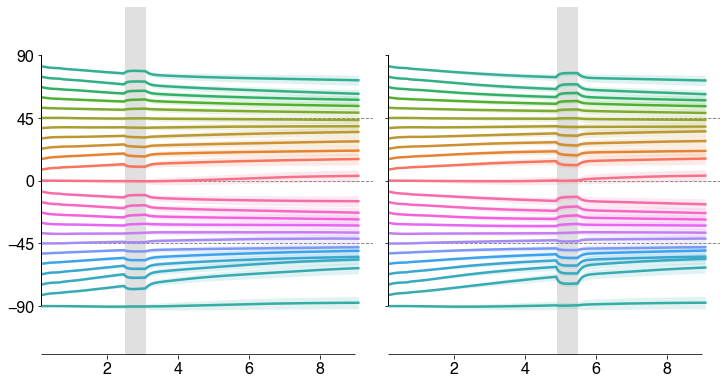

In [18]:
f, ax = plt.subplots(1,2,sharey=True)
utils.set_size([8,4.2])

for i_fig in range(2):
    for s in range(par['n_ori']): 
        ax[i_fig].fill_between(x=np.arange(n_timesteps)*par['dt']/1000., 
                         y1=p_em_readout_m_agg_m[i_fig][:,s]-p_em_readout_m_agg_s[i_fig][:,s], 
                         y2=p_em_readout_m_agg_m[i_fig][:,s]+p_em_readout_m_agg_s[i_fig][:,s], 
                         color=utils.HUSL.colors[s], alpha=0.15, linewidth=0)

        ax[i_fig].plot(np.arange(n_timesteps)*par['dt']/1000.,  
                 p_em_readout_m_agg_m[i_fig][:,s], color=utils.HUSL.colors[s], linewidth=2.5)

    ax[i_fig].set_xlim(left=0.15, right=9.5)
    ax[i_fig].set_ylim([-125,125])
    ax[i_fig].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].axhline(y=45,  color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].axhline(y=-45, color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].axvspan(*times_el[i_fig], color='darkgrey', alpha=0.35, linewidth=0, zorder=-3)
    utils.draw_publish_axis(ax[i_fig], xrange=(0.15,9), yrange=(-90,90), xticks=[2,4,6,8], yticks=[-90,-45,0,45,90])

if utils.LABEL:
    ax[0].set_ylabel(r"Estimation readout $(\!\!^\circ\!\!)$", labelpad=0)
    
plt.savefig(f'{utils.DIR_FIGURE}/fig7f.pdf',bbox_inches='tight')
plt.show()    

In [19]:
p_em_readout_m_agg_m  = np.nan*np.zeros([2,n_timesteps,24])
p_em_readout_m_agg_s  = np.nan*np.zeros([2,n_timesteps,24])
p_em_readout_m_agg_er = np.nan*np.zeros([2,50,n_timesteps,24])

for i_data, v_data in enumerate([resE, resL]):
    em_readout_m_agg_m = utils.circmean(v_data['em_readout_m_agg'],axis=0)
    em_readout_m_agg_er = (v_data['em_readout_m_agg'] - em_readout_m_agg_m[np.newaxis] - 90.) % 180 - 90.
    em_readout_m_agg_s = np.std(em_readout_m_agg_er,axis=0)/np.sqrt(50)
    
    p_em_readout_m_agg_m[i_data] = em_readout_m_agg_m
    p_em_readout_m_agg_s[i_data] = em_readout_m_agg_s
    p_em_readout_m_agg_er[i_data] = em_readout_m_agg_er

In [20]:
ssb_one = np.nan*np.zeros((50,24))
for i_m in range(50):
    sub_err = np.concatenate([err_concat[i_m],err_concat[i_m+50]],axis=-1)
    for i_s in range(24):
        ssb_one[i_m,i_s] = utils.circmean(sub_err[i_s,3:6])

sse_sim = np.nan*np.empty((n_timesteps,50,2)) # last dimension is fcb/dcb
for i_m in range(50): 
    ssb    = ssb_one[i_m]
    for i_t, v_t in enumerate([1,2]):
        for i_tr in range(n_timesteps):
            pattn  = p_em_readout_m_agg_er[i_t,i_m,i_tr]
            nonnan = (~np.isnan(pattn)) & (~np.isnan(ssb))
            reg    = LinearRegression(fit_intercept=False).fit(ssb[nonnan].reshape(-1,1),pattn[nonnan])
            sse_sim[i_tr,i_m,i_t] = reg.coef_[0]

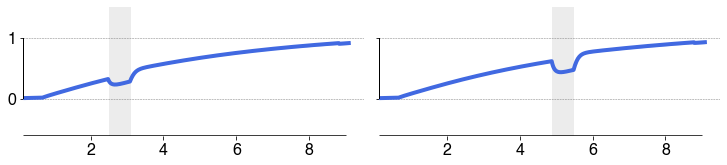

In [21]:
f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([8,1.9])

ax[0].axvspan(10,14,color='darkgray',alpha=0.35,linewidth=0, zorder=-3)
ax[1].axvspan(16,20,color='darkgray',alpha=0.35,linewidth=0, zorder=-3)

for i_fig in range(2):
    mmm = np.mean(sse_sim[:,:,i_fig],axis=1)
    sss = np.std(sse_sim[:,:,i_fig],axis=1)/np.sqrt(50)
    ax[i_fig].axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)
    ax[i_fig].axhline(y=1, color='gray', linestyle='dashed', linewidth=0.5)
    
    ax[i_fig].plot(np.arange(n_timesteps)/50, mmm, linewidth=4, color='#4169e1')
    ax[i_fig].fill_between(np.arange(n_timesteps)/50, mmm-sss, mmm+sss, alpha=0.3, linewidth=0, color='#4169e1')
    ax[i_fig].set_ylim([-0.6,1.5])
    ax[i_fig].set_xlim(left=0.15, right=9.5)
    ax[i_fig].axvspan(*times_el[i_fig], color='grey', alpha=0.15, linewidth=0)
    utils.draw_publish_axis(ax[i_fig], xrange=(0.15,9), yrange=(0,1), xticks=[2,4,6,8], yticks=[0,1])

if utils.LABEL:
    ax[0].set_xlabel(r"Time from trial onset (s)")
    ax[1].set_xlabel(r"Time from trial onset (s)")
    ax[0].set_ylabel(r"Bias weight", labelpad=8)
     
plt.savefig(f'{utils.DIR_FIGURE}/fig7g.pdf',bbox_inches='tight')
plt.show()

In [22]:
p_cm_agg_m = np.nan*np.zeros([2,2,n_timesteps])
p_cm_agg_s = np.nan*np.zeros([2,2,n_timesteps])

for i_data, v_data in enumerate([resE, resL]):
    cm_agg_m = np.mean(v_data['cm_agg'],axis=0)
    cm_agg_s = np.std(v_data['cm_agg'],axis=0)/np.sqrt(50)
    
    p_cm_agg_m[i_data] = cm_agg_m
    p_cm_agg_s[i_data] = cm_agg_s

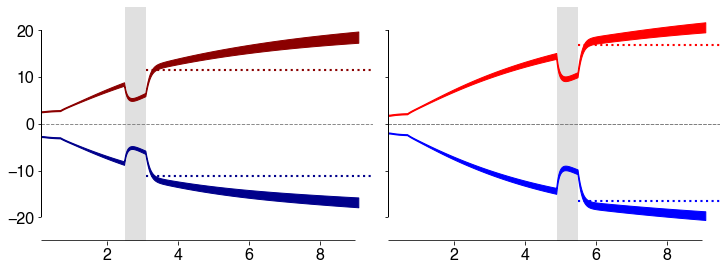

In [23]:
f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([8,3])

plt.axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9)

for i_fig in range(2):
    red  = 'red'  if i_fig==1 else 'darkred'
    blue = 'blue' if i_fig==1 else 'darkblue'
    
    ax[i_fig].fill_between(x=np.arange(n_timesteps)*par['dt']/1000., 
                           y1=p_cm_agg_m[i_fig][1]-p_cm_agg_s[i_fig][1], 
                           y2=p_cm_agg_m[i_fig][1]+p_cm_agg_s[i_fig][1], 
                           color=blue, alpha=1)
    ax[i_fig].fill_between(x=np.arange(n_timesteps)*par['dt']/1000., 
                           y1=p_cm_agg_m[i_fig][0]-p_cm_agg_s[i_fig][0], 
                           y2=p_cm_agg_m[i_fig][0]+p_cm_agg_s[i_fig][0], 
                           color=red, alpha=1)

    ax[i_fig].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].set_ylim([-25,25])
    ax[i_fig].set_xlim(left=0.15, right=9.5)
    ax[i_fig].axvspan(*times_el[i_fig], color='darkgray', alpha=0.35, linewidth=0, zorder=-3)
    ax[i_fig].hlines(y=p_cm_agg_m[i_fig][1][int(times_el[i_fig][-1]*50)+10], xmin=times_el[i_fig][-1], xmax=9.5, color=blue, linestyle='dotted', linewidth=2.1)
    ax[i_fig].hlines(y=p_cm_agg_m[i_fig][0][int(times_el[i_fig][-1]*50)+10], xmin=times_el[i_fig][-1], xmax=9.5, color=red, linestyle='dotted', linewidth=2.1)
    utils.draw_publish_axis(ax[i_fig], xrange=(0.15,9), yrange=(-20,20), xticks=[2,4,6,8], yticks=[-20,-10,0,10,20])
    
if utils.LABEL:
    ax[0].set_xlabel(r"Time from trial onset (s)")    
    ax[1].set_xlabel(r"Time from trial onset (s)")    
    ax[0].set_ylabel(r"Estimation error $(\!\!^\circ\!\!)$", labelpad=0)

plt.savefig(f'{utils.DIR_FIGURE}/fig7h.pdf',bbox_inches='tight')
plt.show()

----
### Near-reference variability

In [24]:
ref_relative = np.arange(-22.5,22.5+0.1,step=7.5)
net_quantile = np.nan*np.zeros([50,len(ref_relative),3])
for i_net in range(50):
    net_err_concat = np.concatenate([err_concat[i_net],err_concat[i_net+50]],axis=0)
    for i_r, v_r in enumerate(ref_relative):
        error = net_err_concat[:,i_r+1].flatten()
        net_quantile[i_net,i_r,0] = np.quantile(error,0.25)
        net_quantile[i_net,i_r,1] = np.quantile(error,0.50)
        net_quantile[i_net,i_r,2] = np.quantile(error,0.75) 
        
m_quant = np.mean(net_quantile[:,:,2]-net_quantile[:,:,0],axis=0)
s_quant = np.std(net_quantile[:,:,2]-net_quantile[:,:,0],axis=0)/np.sqrt(50)

In [25]:
# emonly case
err_concat_eo   = np.concatenate([resE_emonly['er_behav_agg'],resL_emonly['er_behav_agg']],axis=0)
net_quantile_eo = np.nan*np.zeros([50,len(ref_relative),3])
for i_net in range(50):
    net_err_concat = np.concatenate([err_concat_eo[i_net],err_concat_eo[i_net+50]],axis=0)
    for i_r, v_r in enumerate(ref_relative):
        error = net_err_concat[:,i_r+1].flatten()
        net_quantile_eo[i_net,i_r,0] = np.quantile(error,0.25)
        net_quantile_eo[i_net,i_r,1] = np.quantile(error,0.50)
        net_quantile_eo[i_net,i_r,2] = np.quantile(error,0.75) 
        
m_quant_eo = np.mean(net_quantile_eo[:,:,2]-net_quantile_eo[:,:,0],axis=0)
s_quant_eo = np.std(net_quantile_eo[:,:,2]-net_quantile_eo[:,:,0],axis=0)/np.sqrt(50)

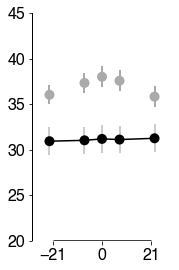

In [26]:
idx = np.array([0,2,3,4,6])

plt.figure()
ax = plt.gca()
utils.set_size([2.1,3])

plt.vlines([-22.5,-7.5,0,7.5,22.5], (m_quant-s_quant)[idx], (m_quant+s_quant)[idx], color='#AAAAAA', alpha=1, linewidth=2)
plt.scatter([-22.5,-7.5,0,7.5,22.5], m_quant[idx], color='#AAAAAA', edgecolor='none', s=100, alpha=1)

plt.vlines([-22.5,-7.5,0,7.5,22.5], (m_quant_eo-s_quant_eo)[idx], (m_quant_eo+s_quant_eo)[idx], color='k', alpha=0.2, linewidth=2)
plt.scatter([-22.5,-7.5,0,7.5,22.5], m_quant_eo[idx], color='k', edgecolor='none', s=100, alpha=1)
plt.plot([-22.5,-7.5,0,7.5,22.5], m_quant_eo[idx], color='k')

plt.ylim([20,45])
plt.xlim([-30,30])

if utils.LABEL:
    ax.set_xlabel(f"Stimulus - Reference $(\!\!^\circ\!\!)$", labelpad=5)
    ax.set_ylabel(f"Interquartile range $(\!\!^\circ\!\!)$", labelpad=5)

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(20,45), xticks=[-21,0,21], yticks=[20,25,30,35,40,45])
plt.savefig(f'{utils.DIR_FIGURE}/fig7j_left.pdf',bbox_inches='tight')
plt.show()

---
### RNN post-decision biases

In [27]:
import scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import statsmodels.api as sm

In [28]:
n_sam = 100000
def nll_EL(par, evi, dm, tim):
    m, s1, s2_add, lam = par
    s2        = np.sqrt(s1**2 + s2_add**2)
    probE     = utils.psi(evi[tim==1], m, s1, lam)
    probL     = utils.psi(evi[tim==2], m, s2, lam)
    sumE_ll   = np.sum(np.log(probE[dm[tim==1]==1])) + np.sum(np.log(1.-probE[dm[tim==1]==0]))
    sumL_ll   = np.sum(np.log(probL[dm[tim==2]==1])) + np.sum(np.log(1.-probL[dm[tim==2]==0]))
    return -sumE_ll - sumL_ll

In [29]:
# this can take some time (~1min)
res_mat = np.nan*np.zeros([50,4])
for i_model in range(50):
    _timing = np.repeat([1,2], n_ori*9*n_batch)
    _evi    = -np.tile( np.repeat( np.arange(-30,30+utils.EPS,step=7.5), n_batch ), 2*n_ori )
    _dm     = 1-np.stack([resE['dm_behav_agg'][i_model], resL['dm_behav_agg'][i_model]])
    _dm     = _dm.flatten()

    res = minimize(nll_EL, [0,5.,5.,0], args = (_evi, _dm, _timing), 
                   bounds = [[-30., 30.], [utils.EPS, 30.], [utils.EPS, 10.], [utils.EPS, 0.5]])
    res_mat[i_model, :] = res['x']    

In [30]:
cmd_indv = np.nan*np.zeros((50,2,2)) # EL / CWCCW
cmd_pred = np.nan*np.zeros((50,2,2)) # EL / CWCCW

for i_model in range(50):
    err_e = resE['er_behav_agg'][i_model][:,3:6,:].flatten()
    err_l = resL['er_behav_agg'][i_model][:,3:6,:].flatten()
    dm_e  = resE['dm_behav_agg'][i_model][:,3:6,:].flatten()
    dm_l  = resL['dm_behav_agg'][i_model][:,3:6,:].flatten()

    cmd_indv[i_model,0,0] = err_e[dm_e==0].mean()
    cmd_indv[i_model,0,1] = err_e[dm_e==1].mean()
    cmd_indv[i_model,1,0] = err_l[dm_l==0].mean()
    cmd_indv[i_model,1,1] = err_l[dm_l==1].mean()
    
    lin = LinearRegression().fit(np.tile( np.repeat([-7.5,0,7.5],n_batch),50*n_ori )[:,None], 
                                 resE['em_behav_agg'][:,:,3:6,:].flatten())
    b_e = lin.coef_[0]
    lin = LinearRegression().fit(np.tile( np.repeat([-7.5,0,7.5],n_batch),50*n_ori )[:,None],
                                 resL['em_behav_agg'][:,:,3:6,:].flatten())
    b_l = lin.coef_[0]
    
    _s1  = res_mat[i_model,1]
    _s2  = np.sqrt(_s1**2 + res_mat[i_model,2]**2)
    r   = np.random.choice([-7.5,0,7.5],size=n_sam)
    x_e = norm.rvs(loc=res_mat[i_model,0], scale=_s1, size=n_sam); d_e = (x_e>r)*1
    x_l = norm.rvs(loc=res_mat[i_model,0], scale=_s2, size=n_sam); d_l = (x_l>r)*1
    
    # attraction correction
    x_e = (1.-b_e)*x_e + b_e*r # 21  #r
    x_l = (1.-b_l)*x_l + b_l*r # 21  #r
    
    # # With lapses
    lam_e = np.random.choice([0,1], len(d_e), p=[1.-res_mat[i_model,3]*2, res_mat[i_model,3]*2], replace=True)
    lam_l = np.random.choice([0,1], len(d_l), p=[1.-res_mat[i_model,3]*2, res_mat[i_model,3]*2], replace=True)
    d_e[lam_e==1] = np.random.choice([0,1], sum(lam_e), p=[0.5,0.5], replace=True)
    d_l[lam_l==1] = np.random.choice([0,1], sum(lam_l), p=[0.5,0.5], replace=True)
    
    cmd_pred[i_model,0,0] = x_e[d_e==0].mean()
    cmd_pred[i_model,0,1] = x_e[d_e==1].mean()
    cmd_pred[i_model,1,0] = x_l[d_l==0].mean()
    cmd_pred[i_model,1,1] = x_l[d_l==1].mean()

In [31]:
# [n_subj, early/late]
bpre    = (cmd_pred[:,:,1] - cmd_pred[:,:,0])/2.
bpost   = (cmd_indv[:,:,1] - cmd_indv[:,:,0])/2. - bpre
d_bpre  = bpre[:,1]  - bpre[:,0]
d_bpost = bpost[:,1] - bpost[:,0]

In [32]:
X = np.array([d_bpre]).T
y = np.array([d_bpost]).T
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

spear = spearmanr(d_bpre,d_bpost)
pears = pearsonr(d_bpre,d_bpost)
pears_CI = utils.pearson_CI(d_bpre,d_bpost)
print('Relation between d_bpre and d_bpost')
print('\nLinear regression')
print(f'Coefficient: {est2.params[-1]}')
print(f'p-value: {est2.pvalues[-1]}')
print('\nCorrelation coefficient')
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)

Relation between d_bpre and d_bpost

Linear regression
Coefficient: -1.8649376231859092
p-value: 1.943269331867203e-05

Correlation coefficient
Pearson r= -0.5646458833428485 p= 1.943269331867192e-05
Pearson CI= (-0.7284972273045398, -0.33968587880561946)
Spearman rho= -0.5539975990396159 p= 2.996459794872783e-05


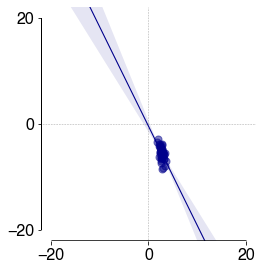

In [33]:
lim = 22
plt.figure()
ax = plt.gca()
utils.set_size([3,3])

plt.axvline(x=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.axhline(y=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.scatter(d_bpre, d_bpost, color='darkblue', alpha=0.5, s=50)

x_line  = np.linspace(-lim,lim,100)
x_mean  = np.mean(d_bpre)
se_line = est2.scale * (1/50 + (x_line-x_mean)**2/np.sum((d_bpre-x_mean)**2))
se_line = se_line**0.5
y_line = est2.params[0] + x_line * est2.params[1]
plt.plot(x_line, y_line, color='darkblue', linewidth=1.1)
plt.fill_between(x_line, y_line-se_line, y_line+se_line, color='darkblue', alpha=0.1, linewidth=0, zorder=-3)

plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(-20,20), yrange=(-20,20), xticks=[-20,0,20], yticks=[-20,0,20])
plt.savefig(f'{utils.DIR_FIGURE}/fig7i_left.pdf',bbox_inches='tight')
plt.show()

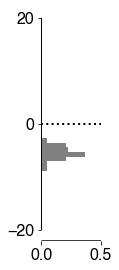

In [34]:
lim = 22
plt.figure()
ax = plt.gca()
utils.set_size([1.5,3])

plt.axhline(y=0, linestyle='dotted', color='k', linewidth=2)
plt.hist(d_bpost, bins=50, range=[-lim,lim], color='gray', 
         orientation='horizontal', density=True)

plt.xlim([0,0.5])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(0,0.5), yrange=(-20,20), xticks=None, yticks=[-20,0,20])
plt.savefig(f'{utils.DIR_FIGURE}/fig7i_right.pdf',bbox_inches='tight')
plt.show()

In [35]:
ttest  = DescrStatsW(d_bpost)
wilcox = wilcoxon(d_bpost)
print("d_bpost vs. 0")
print('\nOne-sample t-test (two-sided)')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nOne-sample t-test (one-sided)')
if ttest.ttest_mean()[0] < 0:
    p_val = ttest.ttest_mean()[1]/2
else:
    p_val = (1.-ttest.ttest_mean()[1])/2
print('t(49)=',  ttest.ttest_mean()[0], 'p=', p_val)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

d_bpost vs. 0

One-sample t-test (two-sided)
t(49)= -31.129119475036088 p= 6.090615579257891e-34
95% CI= (-5.76520196622215, -5.065982688293356)

One-sample t-test (one-sided)
t(49)= -31.129119475036088 p= 3.0453077896289456e-34

Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 7.556929455863566e-10
